<a href="https://colab.research.google.com/github/gabrieldaiess/Style-Transfer-in-R/blob/main/VGG19_Model_Style_Transfer_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

install.packages("jpeg")
install.packages("keras")
install.packages("tensorflow")
library(keras)
library(tensorflow)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



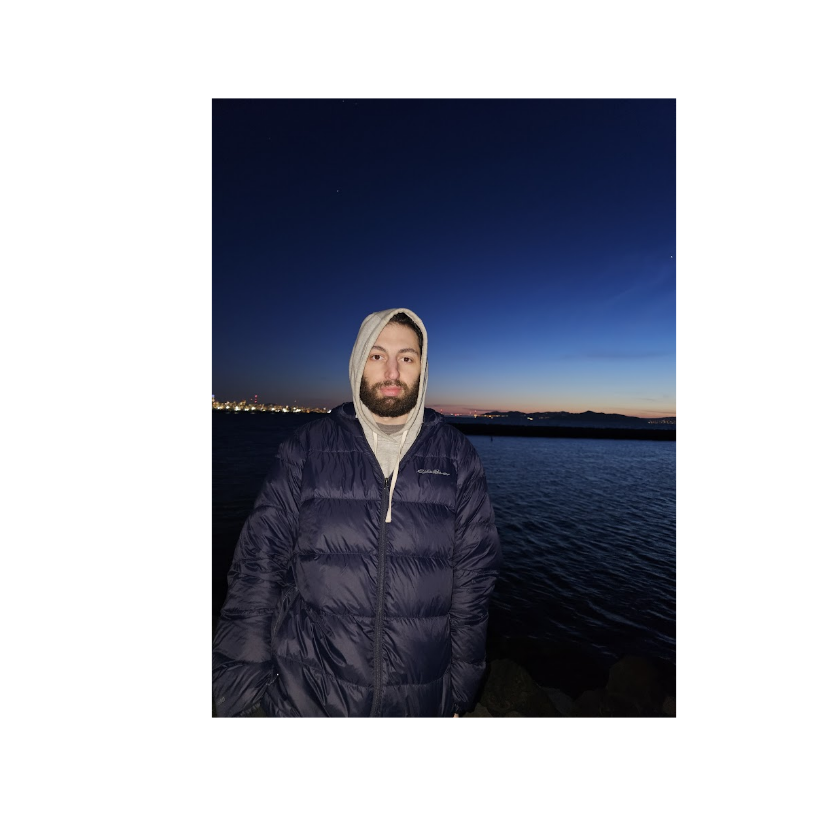

In [ ]:
base_image_path <-"/content/gabriel.jpg"

plot(as.raster(jpeg::readJPEG(base_image_path)))

In [ ]:
model <- application_inception_v3(weights = "imagenet", include_top = FALSE)


In [ ]:
layer_settings <- c(
  "mixed4" = 1.0,
  "mixed5" = 1.5,
  "mixed6" = 2.0,
  "mixed7" = 2.5
)

outputs <- list()
for(layer_name in names(layer_settings))
  outputs[[layer_name]] <- get_layer(model, layer_name)$output

feature_extractor <- keras_model(inputs = model$inputs,
                                 outputs = outputs)



In [ ]:
compute_loss <- function(input_image) {
  features <- feature_extractor(input_image)

  feature_losses <- names(features) %>%
    lapply(function(name) {
      coeff <- layer_settings[[name]]
      activation <- features[[name]]
      coeff * mean(activation[, 3:-3, 3:-3, ] ^ 2)
    })

  Reduce(`+`, feature_losses)
}



In [ ]:
gradient_ascent_step <- tf_function(
  function(image, learning_rate) {

    with(tf$GradientTape() %as% tape, {
      tape$watch(image)
      loss <- compute_loss(image)
    })

    grads <- tape$gradient(loss, image) %>%
      tf$math$l2_normalize()

    image %<>% `+`(learning_rate * grads)

    list(loss, image)
  })

gradient_ascent_loop <-
  function(image, iterations, learning_rate, max_loss = -Inf) {

    learning_rate %<>% as_tensor()

    for(i in seq(iterations)) {

      c(loss, image) %<-% gradient_ascent_step(image, learning_rate)

      loss %<>% as.numeric()
      if(loss > max_loss)
        break

      writeLines(sprintf(
        "... Loss value at step %i: %.2f", i, loss))
    }

    image
  }


In [ ]:
step <- 20
num_octaves <- 3L
octave_scale <- 1.4
iterations <- 30
max_loss <- 15


In [ ]:
preprocess_image <- tf_function(function(image_path) {
  image_path %>%
    tf$io$read_file() %>%
    tf$io$decode_image() %>%
    tf$expand_dims(axis = 0L) %>%
    tf$cast("float32") %>%
    inception_v3_preprocess_input()
})

deprocess_image <- tf_function(function(img) {
  img %>%
    tf$squeeze(axis = 0L) %>%
    { (. * 127.5) + 127.5 } %>%
    tf$saturate_cast("uint8")
})


display_image_tensor <- function(x, ..., max = 255,
                                 plot_margins = c(0, 0, 0, 0)) {

  if (!is.null(plot_margins))
    withr::local_par(mar = plot_margins)

  x %>%
    as.array() %>%
    drop() %>%
    as.raster(max = max) %>%
    plot(..., interpolate = FALSE)
}


In [ ]:
base_image_path <-"/content/gabriel.jpg"

style_reference_image_path <- "/content/starry_night.jpg"

c(original_height, original_width) %<-% {
  base_image_path %>%
    tf$io$read_file() %>%
    tf$io$decode_image() %>%
    dim() %>% .[1:2]
}
img_height <- 400
img_width <- round(img_height * (original_width /
                                   original_height))


In [ ]:
preprocess_image <- function(image_path) {
  image_path %>%
    tf$io$read_file() %>%
    tf$io$decode_image() %>%
    tf$image$resize(as.integer(c(img_height, img_width))) %>%
    k_expand_dims(axis = 1) %>%
    imagenet_preprocess_input()
}

deprocess_image <- tf_function(function(img) {
  if (length(dim(img)) == 4)
    img <- k_squeeze(img, axis = 1)

  c(b, g, r) %<-% {
    img %>%
      k_reshape(c(img_height, img_width, 3)) %>%
      k_unstack(axis = 3)
  }

  r %<>% `+`(123.68)
  g %<>% `+`(103.939)
  b %<>% `+`(116.779)

  k_stack(c(r, g, b), axis = 3) %>%
    k_clip(0, 255) %>%
    k_cast("uint8")
})


In [ ]:
model <- application_vgg19(weights = "imagenet", include_top = FALSE)

outputs <- list()
for (layer in model$layers)
  outputs[[layer$name]] <- layer$output

feature_extractor <- keras_model(inputs = model$inputs,
                                 outputs = outputs)


In [ ]:
content_loss <- function(base_img, combination_img)
    sum((combination_img - base_img)^2)


In [ ]:
gram_matrix <- function(x) {
  n_features <- tf$shape(x)[3]
  x %>%
    tf$reshape(c(-1L, n_features)) %>%
    tf$matmul(., ., transpose_a = TRUE)
}

style_loss <- function(style_img, combination_img) {
  S <- gram_matrix(style_img)
  C <- gram_matrix(combination_img)
  channels <- 3
  size <- img_height * img_width
  sum((S - C) ^ 2) /
    (4 * (channels ^ 2) * (size ^ 2))
}


In [ ]:
total_variation_loss <- function(x) {
  a <- k_square(x[, NA:(img_height-1), NA:(img_width-1), ] -
                x[, 2:NA             , NA:(img_width-1), ])
  b <- k_square(x[, NA:(img_height-1), NA:(img_width-1), ] -
                x[, NA:(img_height-1), 2:NA            , ])
  sum((a + b) ^ 1.25)
}

In [ ]:
style_layer_names <- c(
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
)
content_layer_name <- "block5_conv2"
total_variation_weight <- 1e-6
content_weight <- 2.5e-8
style_weight <- 1e-6

compute_loss <-
  function(combination_image, base_image, style_reference_image) {

    input_tensor <-
      list(base_image,
           style_reference_image,
           combination_image) %>%
      k_concatenate(axis = 1)

    features <- feature_extractor(input_tensor)
    layer_features <- features[[content_layer_name]]
    base_image_features <- layer_features[1, , , ]
    combination_features <- layer_features[3, , , ]

    loss <- 0
    loss %<>% `+`(
      content_loss(base_image_features, combination_features) *
        content_weight
    )

    for (layer_name in style_layer_names) {
      layer_features <- features[[layer_name]]
      style_reference_features <- layer_features[2, , , ]
      combination_features <- layer_features[3, , , ]

      loss %<>% `+`(
        style_loss(style_reference_features, combination_features) *
          style_weight / length(style_layer_names)
      )
    }

    loss %<>% `+`(
      total_variation_loss(combination_image) *
        total_variation_weight
    )

    loss
  }


In [ ]:
compute_loss_and_grads <- tf_function(
  function(combination_image, base_image, style_reference_image) {
    with(tf$GradientTape() %as% tape, {
      loss <- compute_loss(combination_image,
                           base_image,
                           style_reference_image)
    })
    grads <- tape$gradient(loss, combination_image)
    list(loss, grads)
  })

optimizer <- optimizer_sgd(
  learning_rate_schedule_exponential_decay(
    initial_learning_rate = 100, decay_steps = 100, decay_rate = 0.96))



optimizer <-
  optimizer_sgd(learning_rate = learning_rate_schedule_exponential_decay(
    initial_learning_rate = 100,
    decay_steps = 100,
    decay_rate = 0.96
  ))


base_image <- preprocess_image(base_image_path)
style_reference_image <- preprocess_image(style_reference_image_path)
combination_image <- tf$Variable(preprocess_image(base_image_path))


Iteration 100: loss = 3898.91
Iteration 200: loss = 3514.07


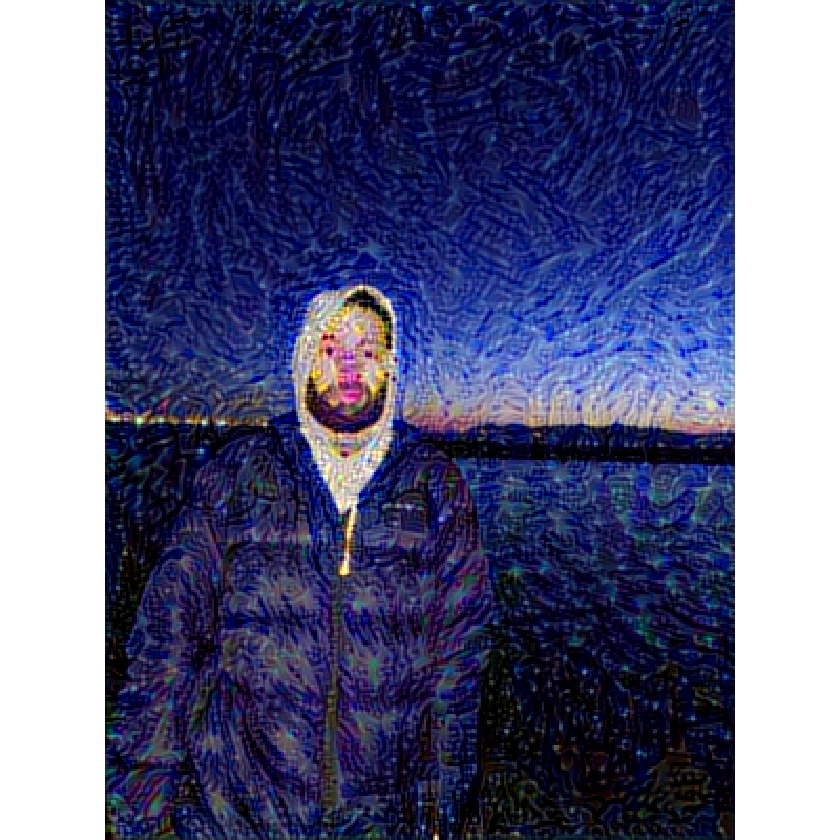

Iteration 300: loss = 3347.21


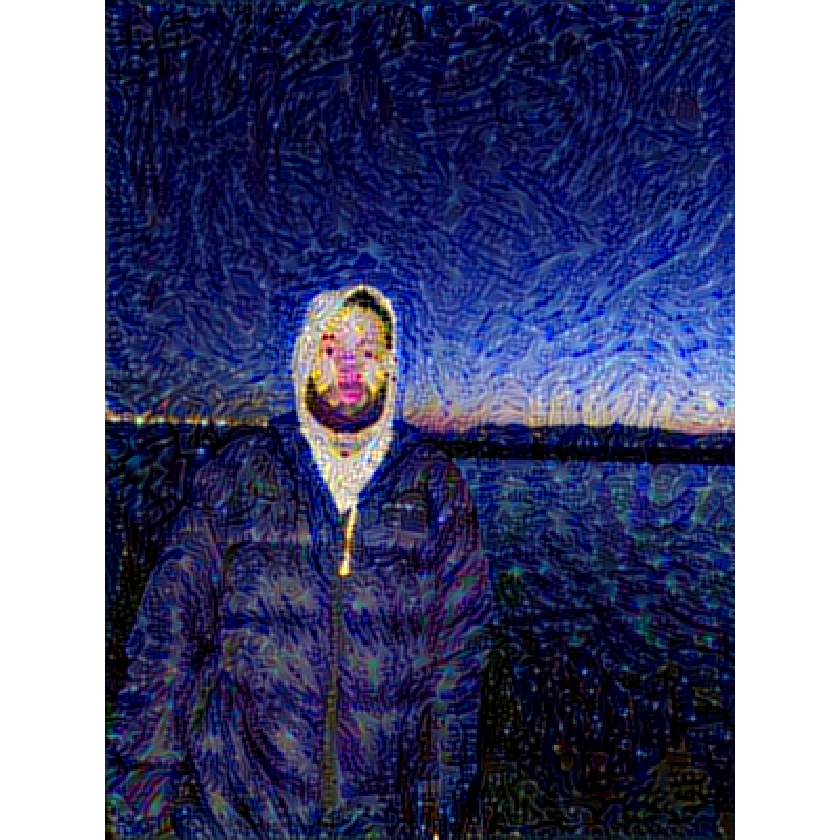

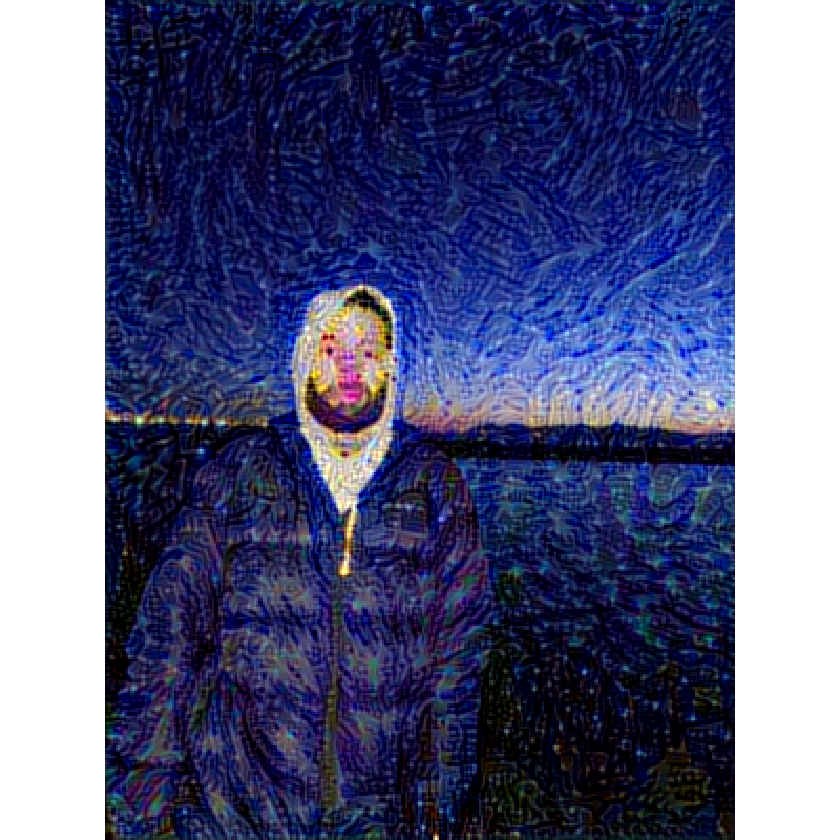

In [ ]:
output_dir <- fs::path("style-transfer-generated-images")
iterations <- 300
for (i in seq(iterations)) {
  c(loss, grads) %<-% compute_loss_and_grads(
    combination_image, base_image, style_reference_image)

  optimizer$apply_gradients(list(
    tuple(grads, combination_image)))

  if ((i %% 100) == 0) {
    cat(sprintf("Iteration %i: loss = %.2f\n", i, loss))
    img <- deprocess_image(combination_image)
    display_image_tensor(img)
    fname <- sprintf("combination_image_at_iteration_%04i.png", i)
    tf$io$write_file(filename = output_dir / fname,
                     contents = tf$io$encode_png(img))
  }
}